# (Optional) Colab Setup
If you aren't using Colab, you can delete the following code cell. This is just to help students with mounting to Google Drive to access the other .py files and downloading the data, which is a little trickier on Colab than on your local machine using Jupyter. 

In [ ]:
# you will be prompted with a window asking to grant permissions
from google.colab import drive
drive.mount("/content/drive")

In [3]:
# fill in the path in your Google Drive in the string below. Note: do not escape slashes or spaces
import os
datadir = "/content/assignment3"
if not os.path.exists(datadir):
  !ln -s "/content/drive/My Drive/Your/assignment3/path/" $datadir # TODO: Fill your assignment3 path
os.chdir(datadir)
!pwd

ln: /content/assignment3: No such file or directory


FileNotFoundError: [Errno 2] No such file or directory: '/content/assignment3'

# Data Setup

The first thing to do is implement a dataset class to load rotated CIFAR10 images with matching labels. Since there is already a CIFAR10 dataset class implemented in `torchvision`, we will extend this class and modify the `__get_item__` method appropriately to load rotated images.

Each rotation label should be an integer in the set {0, 1, 2, 3} which correspond to rotations of 0, 90, 180, or 270 degrees respectively.

In [1]:
!pip install torch torchvision
import torch
import torchvision
import torchvision.transforms as transforms
import numpy as np
import random


def rotate_img(img, rot):
    if rot == 0: # 0 degrees rotation
        return img
    # TODO: Implement rotate_img() - return the rotated img
    #
    #
    #
    elif rot == 1: # 90 degrees rotation
        return torch.rot90(img, 1, [1, 2])
    elif rot == 2: # 180 degrees rotation
        return torch.rot90(img, 2, [1, 2])
    elif rot == 3: # 270 degrees rotation
        return torch.rot90(img, 3, [1, 2])
    else:
        raise ValueError('rotation should be 0, 90, 180, or 270 degrees')


class CIFAR10Rotation(torchvision.datasets.CIFAR10):

    def __init__(self, root, train, download, transform) -> None:
        super().__init__(root=root, train=train, download=download, transform=transform)
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index: int):
        image, cls_label = super().__getitem__(index)

        # randomly select image rotation
        rotation_label = random.choice([0, 1, 2, 3])
        image_rotated = rotate_img(image, rotation_label)

        rotation_label = torch.tensor(rotation_label).long()
        return image, image_rotated, rotation_label, torch.tensor(cls_label).long()

In [3]:
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])
#For task1, the batchsize=128
#For task4.1 and task4.2, the batchsize=512
batch_size = 128

trainset = CIFAR10Rotation(root='./data', train=True,
                                        download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=0)

testset = CIFAR10Rotation(root='./data', train=False,
                                       download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=0)

Files already downloaded and verified
Files already downloaded and verified


Show some example images and rotated images with labels:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.9802322e-08..1.0].


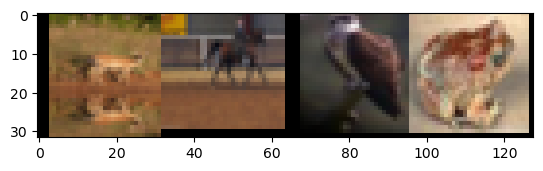

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.9802322e-08..1.0].


Class labels:  deer  horse bird  frog 


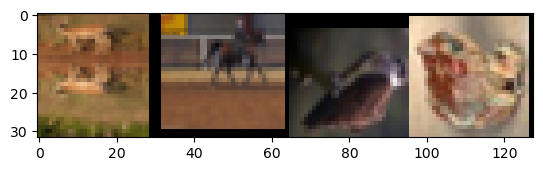

Rotation labels:  180   0     270   90   


In [6]:
import matplotlib.pyplot as plt

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

rot_classes = ('0', '90', '180', '270')


def imshow(img):
    # unnormalize
    img = transforms.Normalize((0, 0, 0), (1/0.2023, 1/0.1994, 1/0.2010))(img)
    img = transforms.Normalize((-0.4914, -0.4822, -0.4465), (1, 1, 1))(img)
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


dataiter = iter(trainloader)
images, rot_images, rot_labels, labels = next(dataiter)

# print images and rotated images
img_grid = imshow(torchvision.utils.make_grid(images[:4], padding=0))
print('Class labels: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))
img_grid = imshow(torchvision.utils.make_grid(rot_images[:4], padding=0))
print('Rotation labels: ', ' '.join(f'{rot_classes[rot_labels[j]]:5s}' for j in range(4)))

# Evaluation code

In [9]:
#part1
import time

def run_test(net, testloader, criterion, task):
    correct = 0
    total = 0
    avg_test_loss = 0.0
    # since we're not training, we don't need to calculate the gradients for our outputs
    with torch.no_grad():
        for images, images_rotated, labels, cls_labels in testloader:
            if task == 'rotation':
              images, labels = images_rotated.to(device), labels.to(device)
            elif task == 'classification':
              images, labels = images.to(device), cls_labels.to(device)
            # TODO: Calculate outputs by running images through the network
            # The class with the highest energy is what we choose as prediction
            #
            #
            #
            outputs = net(images)
            
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            # loss
            avg_test_loss += criterion(outputs, labels)  / len(testloader)



In [8]:
#part4
import time

def run_test(net, testloader, criterion, task):
    correct = 0
    total = 0
    avg_test_loss = 0.0
    # since we're not training, we don't need to calculate the gradients for our outputs
    with torch.no_grad():
        for images, images_rotated, labels, cls_labels in testloader:
            if task == 'rotation':
              images, labels = images_rotated.to(device), labels.to(device)
            elif task == 'classification':
              images, labels = images.to(device), cls_labels.to(device)
            # TODO: Calculate outputs by running images through the network
            # The class with the highest energy is what we choose as prediction
            #
            #
            #
            outputs = net(images)
            
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            # loss
            avg_test_loss += criterion(outputs, labels)  / len(testloader)
#part4 added
    accuracy = 100 * correct / total
    print('TESTING:')
    print(f'Accuracy of the network on the 10000 test images: {100 * correct / total:.2f} %')
    print(f'Average loss on the 10000 test images: {avg_test_loss:.3f}')
    #part4added
    return accuracy, avg_test_loss

In [10]:
def adjust_learning_rate(optimizer, epoch, init_lr, decay_epochs=30):
    """Sets the learning rate to the initial LR decayed by 10 every 30 epochs"""
    lr = init_lr * (0.1 ** (epoch // decay_epochs))
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

## 1. Train a ResNet18 on the rotation task

In this section, we will train a ResNet18 model on the rotation task. The input is a rotated image and the model predicts the rotation label. See the Data Setup section for details.

In [12]:
if torch.backends.mps.is_available():
    device = torch.device("mps")
    print("using MPS(Metal)")
elif torch.cuda.is_available():
    device = torch.device("cuda")
    print("using CUDA")
else:
    device = torch.device("cpu")
    print("using CPU ")

using MPS(Metal)


In [14]:
import torch.nn as nn
import torch.nn.functional as F

from torchvision.models import resnet18

net = resnet18(num_classes=4)
net = net.to(device)

In [16]:
import torch.optim as optim

# TODO: Define criterion and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9, weight_decay=2e-4)
#for task1, lr=0.01 and weight_decay=5e-4
#but for task 4.1 and task4.2, the lr=0.1 and weight_decay=2e-4

In [19]:
#Part1

# Both the self-supervised rotation task and supervised CIFAR10 classification are
# trained with the CrossEntropyLoss, so we can use the training loop code.

def train(net, criterion, optimizer, num_epochs, decay_epochs, init_lr, task='rotation'):

    for epoch in range(num_epochs):  # loop over the dataset multiple times

        running_loss = 0.0
        running_correct = 0.0
        running_total = 0.0
        start_time = time.time()

        net.train()

        for i, (imgs, imgs_rotated, rotation_label, cls_label) in enumerate(trainloader, 0):
            lr = init_lr * (0.2 ** (epoch // decay_epochs))
            for param_group in optimizer.param_groups:
                param_group['lr'] = lr

            # TODO: Set the data to the correct device; Different task will use different inputs and labels
            #
            if task == 'rotation':
                inputs, labels = imgs_rotated.to(device), rotation_label.to(device)
            elif task == 'classification':
                inputs, labels = imgs.to(device), cls_label.to(device)

            # TODO: Zero the parameter gradients
            #
            optimizer.zero_grad()

            # TODO: forward + backward + optimize
            #
            #
            #
            #
            #
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            torch.nn.utils.clip_grad_norm_(net.parameters(), max_norm=1.0)

            # TODO: Get predicted results
            _, predicted = torch.max(outputs.data, 1)

            # print statistics
            print_freq = 100
            running_loss += loss.item()

            # calc acc
            running_total += labels.size(0)
            running_correct += (predicted == labels).sum().item()

            if i % print_freq == (print_freq - 1):    # print every 2000 mini-batches
                print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / print_freq:.3f} acc: {100*running_correct / running_total:.2f} time: {time.time() - start_time:.2f}')
                running_loss, running_correct, running_total = 0.0, 0.0, 0.0
                start_time = time.time()

        # TODO: Run the run_test() function after each epoch; Set the model to the evaluation mode.
        #
        #
        net.eval()
        run_test(net, testloader, criterion, task)

    print('Finished Training')

In [18]:
#PART4
from torch.optim.lr_scheduler import CosineAnnealingLR
import copy 

def train(net, criterion, optimizer, num_epochs, task='rotation'):
    
    best_acc = 0
    best_model_wts = copy.deepcopy(net.state_dict())
    
    scheduler = CosineAnnealingLR(optimizer, T_max=num_epochs, eta_min=1e-6)
    
    for epoch in range(num_epochs):  # loop over the dataset multiple times
        running_loss = 0.0
        running_correct = 0.0
        running_total = 0.0
        start_time = time.time()
        net.train()
        
        for i, (imgs, imgs_rotated, rotation_label, cls_label) in enumerate(trainloader, 0):
            if task == 'rotation':
                inputs, labels = imgs_rotated.to(device), rotation_label.to(device)
            elif task == 'classification':
                inputs, labels = imgs.to(device), cls_label.to(device)

            optimizer.zero_grad()
 
            outputs = net(inputs)
            loss = criterion(outputs, labels)

            loss.backward()
            torch.nn.utils.clip_grad_norm_(net.parameters(), max_norm=1.0)
            optimizer.step()
     
            _, predicted = torch.max(outputs.data, 1)
    
            print_freq = 100
            running_loss += loss.item()
            running_total += labels.size(0)
            running_correct += (predicted == labels).sum().item()
            
            if i % print_freq == (print_freq - 1):
                print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / print_freq:.3f} '
                      f'acc: {100*running_correct / running_total:.2f} '
                      f'time: {time.time() - start_time:.2f}')
                running_loss, running_correct, running_total = 0.0, 0.0, 0.0
                start_time = time.time()
  
        scheduler.step()
   
        net.eval()
        accuracy, test_loss = run_test(net, testloader, criterion, task)

        if accuracy > best_acc:
            best_acc = accuracy
            best_model_wts = copy.deepcopy(net.state_dict())
            print(f'New best accuracy: {best_acc:.2f}%')
        
        print(f'Epoch {epoch+1}/{num_epochs} completed. Best accuracy: {best_acc:.2f}%')

    net.load_state_dict(best_model_wts)
    print(f'Finished Training. Best accuracy: {best_acc:.2f}%')
    
  

In [22]:
#Part1
train(net, criterion, optimizer, num_epochs=45, decay_epochs=20, init_lr=0.01, task='rotation')
torch.save(net.state_dict(), 'rotation_model.pth')

[1,   100] loss: 1.348 acc: 39.07 time: 4.69
[1,   200] loss: 1.180 acc: 47.92 time: 4.32
[1,   300] loss: 1.146 acc: 49.80 time: 4.36
[2,   100] loss: 1.104 acc: 52.53 time: 4.35
[2,   200] loss: 1.078 acc: 53.99 time: 4.48
[2,   300] loss: 1.061 acc: 54.69 time: 4.39
[3,   100] loss: 1.046 acc: 55.62 time: 4.51
[3,   200] loss: 1.019 acc: 56.80 time: 4.37
[3,   300] loss: 1.002 acc: 57.60 time: 4.46
[4,   100] loss: 0.970 acc: 59.16 time: 4.57
[4,   200] loss: 0.980 acc: 58.88 time: 4.43
[4,   300] loss: 0.970 acc: 59.69 time: 4.40
[5,   100] loss: 0.959 acc: 59.77 time: 4.61
[5,   200] loss: 0.937 acc: 61.00 time: 4.39
[5,   300] loss: 0.930 acc: 61.31 time: 4.44
[6,   100] loss: 0.919 acc: 61.25 time: 4.52
[6,   200] loss: 0.904 acc: 62.77 time: 4.37
[6,   300] loss: 0.903 acc: 63.24 time: 4.40
[7,   100] loss: 0.878 acc: 63.15 time: 4.54
[7,   200] loss: 0.882 acc: 63.20 time: 4.43
[7,   300] loss: 0.898 acc: 62.85 time: 4.40
[8,   100] loss: 0.872 acc: 63.77 time: 4.38
[8,   200]

In [22]:

#PART4
train(net, criterion, optimizer, num_epochs=65,task='rotation')

# TODO: Save the model
#
torch.save(net.state_dict(), 'rotation_model.pth')

TESTING:
Accuracy of the network on the 10000 test images: 50.66 %
Average loss on the 10000 test images: 1.262
New best accuracy: 50.66%
Epoch 1/65 completed. Best accuracy: 50.66%
TESTING:
Accuracy of the network on the 10000 test images: 55.30 %
Average loss on the 10000 test images: 1.079
New best accuracy: 55.30%
Epoch 2/65 completed. Best accuracy: 55.30%
TESTING:
Accuracy of the network on the 10000 test images: 58.48 %
Average loss on the 10000 test images: 0.983
New best accuracy: 58.48%
Epoch 3/65 completed. Best accuracy: 58.48%
TESTING:
Accuracy of the network on the 10000 test images: 59.31 %
Average loss on the 10000 test images: 0.993
New best accuracy: 59.31%
Epoch 4/65 completed. Best accuracy: 59.31%
TESTING:
Accuracy of the network on the 10000 test images: 63.19 %
Average loss on the 10000 test images: 0.880
New best accuracy: 63.19%
Epoch 5/65 completed. Best accuracy: 63.19%
TESTING:
Accuracy of the network on the 10000 test images: 63.23 %
Average loss on the 100

## 2.1 Fine-tuning on the pre-trained model

In this section, we will load the pre-trained ResNet18 model and fine-tune on the classification task. We will freeze all previous layers except for the 'layer4' block and 'fc' layer.

In [23]:
import torch.nn as nn
import torch.nn.functional as F

from torchvision.models import resnet18

# TODO: Load the pre-trained ResNet18 model
#
#
#

net = resnet18(num_classes=10)
net = net.to(device)
pretrained_dict = torch.load('rotation_model.pth')
pretrained_dict.pop('fc.weight')
pretrained_dict.pop('fc.bias')
model_dict = net.state_dict()
model_dict.update(pretrained_dict)
net.load_state_dict(model_dict, strict=False)

/var/folders/l3/n_lcwq293xgb2cd8pj8q6ss00000gn/T/ipykernel_48543/2271314707.py:13: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  pretrained_dict = torch.load('rotation_model

<All keys matched successfully>

In [25]:
# TODO: Freeze all previous layers; only keep the 'layer4' block and 'fc' layer trainable
#
#
#
#
for name, param in net.named_parameters():
    if 'layer4' not in name and 'fc' not in name:
        param.requires_grad = False

In [27]:
# Print all the trainable parameters
params_to_update = net.parameters()
print("Params to learn:")
params_to_update = []
for name,param in net.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)
        print("\t",name)

Params to learn:
	 layer4.0.conv1.weight
	 layer4.0.bn1.weight
	 layer4.0.bn1.bias
	 layer4.0.conv2.weight
	 layer4.0.bn2.weight
	 layer4.0.bn2.bias
	 layer4.0.downsample.0.weight
	 layer4.0.downsample.1.weight
	 layer4.0.downsample.1.bias
	 layer4.1.conv1.weight
	 layer4.1.bn1.weight
	 layer4.1.bn1.bias
	 layer4.1.conv2.weight
	 layer4.1.bn2.weight
	 layer4.1.bn2.bias
	 fc.weight
	 fc.bias


In [29]:
# TODO: Define criterion and optimizer
# Note that your optimizer only needs to update the parameters that are trainable.
criterion = nn.CrossEntropyLoss()
params_to_update = []
for name, param in net.named_parameters():
    if param.requires_grad:
        params_to_update.append(param)
optimizer = optim.SGD(params_to_update, lr=0.01, momentum=0.9, weight_decay=5e-4)

In [31]:
train(net, criterion, optimizer, num_epochs=20, decay_epochs=10, init_lr=0.01, task='classification')
torch.save(net.state_dict(), 'finetuned_model.pth')


[1,   100] loss: 1.636 acc: 40.52 time: 2.97
[1,   200] loss: 1.388 acc: 49.58 time: 2.70
[1,   300] loss: 1.336 acc: 51.48 time: 2.73
TESTING:
Accuracy of the network on the 10000 test images: 54.78 %
Average loss on the 10000 test images: 1.266
[2,   100] loss: 1.278 acc: 53.21 time: 2.79
[2,   200] loss: 1.251 acc: 54.66 time: 2.77
[2,   300] loss: 1.232 acc: 55.59 time: 2.79
TESTING:
Accuracy of the network on the 10000 test images: 58.22 %
Average loss on the 10000 test images: 1.161
[3,   100] loss: 1.187 acc: 56.74 time: 2.77
[3,   200] loss: 1.208 acc: 56.52 time: 2.78
[3,   300] loss: 1.193 acc: 56.62 time: 2.77
TESTING:
Accuracy of the network on the 10000 test images: 59.50 %
Average loss on the 10000 test images: 1.136
[4,   100] loss: 1.159 acc: 58.31 time: 2.93
[4,   200] loss: 1.157 acc: 57.77 time: 2.84
[4,   300] loss: 1.160 acc: 57.91 time: 2.95
TESTING:
Accuracy of the network on the 10000 test images: 60.57 %
Average loss on the 10000 test images: 1.110
[5,   100] l

## 2.2 Fine-tuning on the randomly initialized model
In this section, we will randomly initialize a ResNet18 model and fine-tune on the classification task. We will freeze all previous layers except for the 'layer4' block and 'fc' layer.

In [41]:
import torch.nn as nn
import torch.nn.functional as F

from torchvision.models import resnet18

# TODO: Randomly initialize a ResNet18 model
#
#
#
net = resnet18(num_classes=10)
net = net.to(device)

In [44]:
# TODO: Freeze all previous layers; only keep the 'layer4' block and 'fc' layer trainable
# To do this, you should set requires_grad=False for the frozen layers.
#
#
#
for name, param in net.named_parameters():
    if 'layer4' not in name and 'fc' not in name:
        param.requires_grad = False

In [46]:
# Print all the trainable parameters
params_to_update = net.parameters()
print("Params to learn:")
params_to_update = []
for name,param in net.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)
        print("\t",name)

Params to learn:
	 layer4.0.conv1.weight
	 layer4.0.bn1.weight
	 layer4.0.bn1.bias
	 layer4.0.conv2.weight
	 layer4.0.bn2.weight
	 layer4.0.bn2.bias
	 layer4.0.downsample.0.weight
	 layer4.0.downsample.1.weight
	 layer4.0.downsample.1.bias
	 layer4.1.conv1.weight
	 layer4.1.bn1.weight
	 layer4.1.bn1.bias
	 layer4.1.conv2.weight
	 layer4.1.bn2.weight
	 layer4.1.bn2.bias
	 fc.weight
	 fc.bias


In [48]:
# TODO: Define criterion and optimizer
# Note that your optimizer only needs to update the parameters that are trainable.
criterion = nn.CrossEntropyLoss()
params_to_update = []
for name, param in net.named_parameters():
    if param.requires_grad:
        params_to_update.append(param)
optimizer = optim.SGD(params_to_update, lr=0.01, momentum=0.9, weight_decay=5e-4)

In [50]:
train(net, criterion, optimizer, num_epochs=20, decay_epochs=10, init_lr=0.01, task='classification')

[1,   100] loss: 2.145 acc: 23.00 time: 2.83
[1,   200] loss: 1.987 acc: 28.84 time: 2.72
[1,   300] loss: 1.964 acc: 29.21 time: 2.73
TESTING:
Accuracy of the network on the 10000 test images: 34.87 %
Average loss on the 10000 test images: 1.813
[2,   100] loss: 1.892 acc: 31.29 time: 2.82
[2,   200] loss: 1.853 acc: 33.35 time: 2.79
[2,   300] loss: 1.851 acc: 33.38 time: 2.74
TESTING:
Accuracy of the network on the 10000 test images: 37.30 %
Average loss on the 10000 test images: 1.726
[3,   100] loss: 1.813 acc: 34.39 time: 2.87
[3,   200] loss: 1.812 acc: 33.74 time: 2.75
[3,   300] loss: 1.812 acc: 34.05 time: 2.76
TESTING:
Accuracy of the network on the 10000 test images: 37.96 %
Average loss on the 10000 test images: 1.731
[4,   100] loss: 1.788 acc: 35.74 time: 3.07
[4,   200] loss: 1.782 acc: 35.28 time: 2.76
[4,   300] loss: 1.767 acc: 35.76 time: 2.75
TESTING:
Accuracy of the network on the 10000 test images: 39.81 %
Average loss on the 10000 test images: 1.683
[5,   100] l

## 3.1 Supervised training on the pre-trained model
In this section, we will load the pre-trained ResNet18 model and re-train the whole model on the classification task.

In [20]:
import torch.nn as nn
import torch.nn.functional as F

from torchvision.models import resnet18

# TODO: Load the pre-trained ResNet18 model
#
#
#
net = resnet18(num_classes=10)
net = net.to(device)
pretrained_dict = torch.load('rotation_model.pth')
model_dict = net.state_dict()


pretrained_dict.pop('fc.weight')
pretrained_dict.pop('fc.bias')
model_dict.update(pretrained_dict)
net.load_state_dict(model_dict, strict=False)

/var/folders/l3/n_lcwq293xgb2cd8pj8q6ss00000gn/T/ipykernel_69059/1974043346.py:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  pretrained_dict = torch.load('rotation_model

<All keys matched successfully>

In [26]:
# TODO: Define criterion and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9, weight_decay=5e-4)

In [28]:
train(net, criterion, optimizer, num_epochs=20, decay_epochs=10, init_lr=0.01, task='classification')
torch.save(net.state_dict(), 'super.pth')

[1,   100] loss: 1.450 acc: 47.90 time: 4.50
[1,   200] loss: 1.143 acc: 59.40 time: 4.38
[1,   300] loss: 1.062 acc: 62.38 time: 4.38
TESTING:
Accuracy of the network on the 10000 test images: 63.83 %
Average loss on the 10000 test images: 1.053
[2,   100] loss: 0.981 acc: 65.27 time: 4.38
[2,   200] loss: 0.920 acc: 67.70 time: 4.41
[2,   300] loss: 0.901 acc: 68.45 time: 4.51
TESTING:
Accuracy of the network on the 10000 test images: 69.39 %
Average loss on the 10000 test images: 0.884
[3,   100] loss: 0.856 acc: 69.80 time: 4.41
[3,   200] loss: 0.831 acc: 70.61 time: 4.39
[3,   300] loss: 0.811 acc: 71.36 time: 4.40
TESTING:
Accuracy of the network on the 10000 test images: 71.34 %
Average loss on the 10000 test images: 0.818
[4,   100] loss: 0.771 acc: 72.93 time: 4.42
[4,   200] loss: 0.754 acc: 73.55 time: 4.44
[4,   300] loss: 0.772 acc: 72.62 time: 4.41
TESTING:
Accuracy of the network on the 10000 test images: 74.10 %
Average loss on the 10000 test images: 0.746
[5,   100] l

## 3.2 Supervised training on the randomly initialized model
In this section, we will randomly initialize a ResNet18 model and re-train the whole model on the classification task.

In [58]:
import torch.nn as nn
import torch.nn.functional as F

from torchvision.models import resnet18

# TODO: Randomly initialize a ResNet18 model
#
#
#
net = resnet18(num_classes=10)
net = net.to(device)

In [60]:
# TODO: Define criterion and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9, weight_decay=5e-4)

In [62]:
train(net, criterion, optimizer, num_epochs=20, decay_epochs=10, init_lr=0.01, task='classification')

[1,   100] loss: 2.009 acc: 27.71 time: 4.28
[1,   200] loss: 1.703 acc: 37.90 time: 4.18
[1,   300] loss: 1.575 acc: 42.02 time: 4.16
TESTING:
Accuracy of the network on the 10000 test images: 47.79 %
Average loss on the 10000 test images: 1.485
[2,   100] loss: 1.437 acc: 48.25 time: 4.18
[2,   200] loss: 1.392 acc: 49.58 time: 4.16
[2,   300] loss: 1.306 acc: 52.65 time: 4.21
TESTING:
Accuracy of the network on the 10000 test images: 51.61 %
Average loss on the 10000 test images: 1.377
[3,   100] loss: 1.200 acc: 56.65 time: 4.30
[3,   200] loss: 1.175 acc: 57.79 time: 4.27
[3,   300] loss: 1.159 acc: 58.81 time: 4.26
TESTING:
Accuracy of the network on the 10000 test images: 61.54 %
Average loss on the 10000 test images: 1.067
[4,   100] loss: 1.047 acc: 62.84 time: 4.33
[4,   200] loss: 1.054 acc: 62.48 time: 4.19
[4,   300] loss: 1.030 acc: 63.20 time: 4.16
TESTING:
Accuracy of the network on the 10000 test images: 66.50 %
Average loss on the 10000 test images: 0.936
[5,   100] l

In [22]:
#4.2b
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9, weight_decay=3e-4)

train(net, criterion, optimizer, num_epochs=50, task='classification')
torch.save(net.state_dict(), 'super.pth')

[1,   100] loss: 1.567 acc: 44.86 time: 4.69
[1,   200] loss: 1.367 acc: 52.10 time: 4.32
[1,   300] loss: 1.264 acc: 56.08 time: 4.35
TESTING:
Accuracy of the network on the 10000 test images: 55.61 %
Average loss on the 10000 test images: 1.268
New best accuracy: 55.61%
Epoch 1/50 completed. Best accuracy: 55.61%
[2,   100] loss: 1.153 acc: 59.87 time: 4.42
[2,   200] loss: 1.103 acc: 61.22 time: 4.47
[2,   300] loss: 1.045 acc: 63.35 time: 4.68
TESTING:
Accuracy of the network on the 10000 test images: 66.90 %
Average loss on the 10000 test images: 0.955
New best accuracy: 66.90%
Epoch 2/50 completed. Best accuracy: 66.90%
[3,   100] loss: 0.968 acc: 66.53 time: 4.53
[3,   200] loss: 0.939 acc: 67.41 time: 4.41
[3,   300] loss: 0.953 acc: 67.30 time: 4.58
TESTING:
Accuracy of the network on the 10000 test images: 69.16 %
Average loss on the 10000 test images: 0.894
New best accuracy: 69.16%
Epoch 3/50 completed. Best accuracy: 69.16%
[4,   100] loss: 0.892 acc: 68.99 time: 4.60
[4, 